In [27]:
import numpy as np
import if2 as if2
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

# Ilustracja opcji barierowych

0.16
Typ opcji: Up & Out Put
Opcja została dezaktywowana
Moment stopu na przedziale [0,0.25]: 0.16


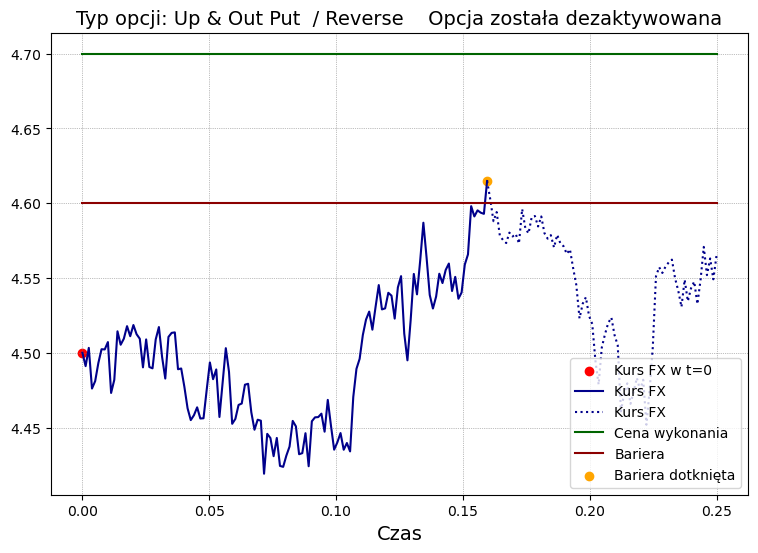

In [31]:
FXspot=4.50
Strike=4.70
Barrier=4.60
r_f=0.02
r_d=0.06
sig=0.1
T=0.25
N=200 # liczba kroków czasowych
dt=T/N # długość kroku czasowego

# Rodzaj opcji
c_p = -1      # call=1  put=-1
if c_p == 1: 
    c_p_type="Call"
elif c_p == -1:
    c_p_type="Put"
in_out  =  -1   # in=1   out=-1
down_up =  -1  # down=1  up=-1

def BSM(S0,r_d,r_f,sig,dt,x): # x z rozkładu N(0,1)
    S1=S0*np.exp((r_d-r_f-0.5*sig**2)*dt+sig*np.sqrt(dt)*x)
    return S1
Time=np.linspace(0,T,N)
Spath=np.zeros(len(Time))
Spath[0]=FXspot
rn=np.random.randn(len(Spath))
for i in range(len(Spath)-1):
    Spath[i+1]=BSM(Spath[i],r_d,r_f,sig,dt,rn[i])
S_max=max(Spath)
S_min=min(Spath)
i=0
while i<N and down_up*(Spath[i]-Barrier)>0: i+=1
if i<N: i_B=i 
else: i_B=N-1
tau_B=(i_B+1)/N*T
print(tau_B)
if in_out==1: # In
    if down_up==1: # Down
        typ_opcji="Typ opcji: Down & In"
        print(typ_opcji+" "+c_p_type)
        if FXspot <= Barrier: 
            print("Zmień FXspot lub barierę")
        if S_min <= Barrier:
            touch_event="Opcja została aktywowana"
            print(touch_event)
            print("Wypłata opcji: ", max(c_p*(Spath[len(Spath)-1]-Strike),0))
        else: 
            touch_event="Opcja nie została aktywowana"
            print(touch_event)
    elif down_up==-1: # Up
        typ_opcji="Typ opcji: Up & In"
        print(typ_opcji+" "+c_p_type)
        if FXspot >= Barrier: 
            print("Zmień FXspot lub barierę")
        if S_max >= Barrier: 
            touch_event="Opcja została aktywowana"
            print(touch_event)
            print("Wypłata opcji: ", max(c_p*(Spath[len(Spath)-1]-Strike),0))
        else: 
            touch_event="Opcja nie została aktywowana"
            print(touch_event)
elif in_out==-1: # Out
    if down_up==1: # Down
        typ_opcji="Typ opcji: Down & Out"
        print(typ_opcji+" "+c_p_type)
        if FXspot <= Barrier: 
            print("Zmień FXspot lub barierę")
        if S_min > Barrier: 
            touch_event="Opcja nie została dezaktywowana"
            print(touch_event)
        else: 
            touch_event="Opcja została dezaktywowana"
            print(touch_event)
    elif down_up==-1: # Up
        if c_p*Barrier < c_p*Strike:
            print("Taka opcja jest bezwartościowa, bo albo opcja jest akywna ale OTM lub zostaje dezaktywowana.")
        typ_opcji="Typ opcji: Up & Out"
        print(typ_opcji+" "+c_p_type)
        if FXspot >= Barrier: 
            print("Zmień FXspot lub barierę")
        if S_max < Barrier: 
            touch_event="Opcja nie została dezaktywowana"
            print(touch_event)
        else: 
            touch_event="Opcja została dezaktywowana"
            print(touch_event)
print(f"Moment stopu na przedziale [0,{T}]: {tau_B}")
Time_B=Time[:i_B+1]
Spath_B=Spath[:i_B+1]
Time_E=Time[i_B:]
Spath_E=Spath[i_B:]
if c_p*Strike > c_p*Barrier: 
    reg_rev="Regular"
else:
    reg_rev="Reverse"
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title(typ_opcji+" "+c_p_type+"  / "+reg_rev+"    "+touch_event,fontsize=14)
axl.set_xlabel("Czas",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.scatter(Time[0],Spath[0],color="red",marker='o',label="Kurs FX w t=0")
if in_out==1:
    plt.plot(Time_B,Spath_B,color="darkblue",linewidth=1.5,label="Kurs FX")
    plt.plot(Time_E,Spath_E,color="darkblue",linestyle="dotted",linewidth=1.5,label="Kurs FX")
else: 
    plt.plot(Time_B,Spath_B,color="darkblue",linewidth=1.5,label="Kurs FX")
    plt.plot(Time_E,Spath_E,color="darkblue",linestyle="dotted",linewidth=1.5,label="Kurs FX")
#plt.plot(Time,Spath,color="darkblue",linestyle="dotted",linewidth=1.5,label="Kurs FX")
plt.plot(Time,[Strike]*N,color="darkgreen",linewidth=1.5,label="Cena wykonania")
plt.plot(Time,[Barrier]*N,color="darkred",linewidth=1.5,label="Bariera")
if Time[i_B] < T:
    plt.scatter(Time[i_B],Spath[i_B],color="orange",marker='o',label="Bariera dotknięta")
#plt.plot(Time[i_B],Spath[i_B],color="orange",marker='o')
plt.legend()

# Formuły na wycenę opcji barierowych

In [8]:
def BSF(omega,eta,X,Y,sig,r_d,r_f,d,T):
    df_d=np.exp(-r_d*T)
    df_f=np.exp(-r_f*T)
    return omega*(df_f*X*norm.cdf(eta*d)-df_d*Y*norm.cdf(eta*(d-np.sqrt(T)*sig)))
def d(X,Y,sig,r_d,r_f,T):
    return (np.log(X/Y)+(r_d-r_f+0.5*sig**2)*T)/(sig*np.sqrt(T))
 
def BS1(omega,S,K,sig,r_d,r_f,T):
    d1 = d(S,K,sig,r_d,r_f,T)
    return BSF(omega,omega,S,K,sig,r_d,r_f,d1,T)

def BS2(omega,S,K,B,sig,r_d,r_f,T):
    d2 = d(S,B,sig,r_d,r_f,T)
    return BSF(omega,omega,S,K,sig,r_d,r_f,d2,T)

def BS3(omega,eta,S,K,B,sig,r_d,r_f,T):
    d3 = d(B**2/S,K,sig,r_d,r_f,T)
    nu = 2*(r_d-r_f)/(sig**2)
    R  = (B/S)**(nu-1)
    return R*BSF(omega,eta,B**2/S,K,sig,r_d,r_f,d3,T)

def BS4(omega,eta,S,K,B,sig,r_d,r_f,T):
    d4 = d(B,S,sig,r_d,r_f,T)
    nu = 2*(r_d-r_f)/(sig**2)
    R  = (B/S)**(nu-1)
    return R*BSF(omega,eta,B**2/S,K,sig,r_d,r_f,d4,T)

def Value_UIC(FXspot,sig,r_d,r_f,Strike,Barrier,T):
    if FXspot<Barrier:            # bariera nie przekroczona, opcja nie aktywowana
        if Strike>Barrier:
            value=BS1(1,FXspot,Strike,sig,r_d,r_f,T)
        else:
            V2=BS2(1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            V3=BS3(1,-1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            V4=BS4(1,-1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            value=V2-V3+V4
    else:                         # bariera przekroczona, opcja aktywowana
        value=BS1(1,FXspot,Strike,sig,r_d,r_f,T)
    return value

def Value_UIP(FXspot,sig,r_d,r_f,Strike,Barrier,T):
    if FXspot<Barrier:            # bariera nie przekroczona, opcja nie aktywowana
        if Strike>Barrier:
            V1=BS1(-1,FXspot,Strike,sig,r_d,r_f,T)
            V2=BS2(-1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            V4=BS4(-1,-1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            value=V1-V2+V4
        else:
            value=BS3(-1,-1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
    else:                         # bariera przekroczona, opcja aktywowana
        value=BS1(-1,FXspot,Strike,sig,r_d,r_f,T)
    return value

def Value_DIP(FXspot,sig,r_d,r_f,Strike,Barrier,T):
    if FXspot>Barrier:            # bariera nie przekroczona, opcja nie aktywowana
        if Strike>Barrier:
            V2=BS2(-1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            V3=BS3(-1,1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            V4=BS4(-1,1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            value=V2-V3+V4
        else:
            value=BS1(-1,FXspot,Strike,sig,r_d,r_f,T)
    else:                          # bariera przekroczona, opcja aktywowana
        value=BS1(-1,FXspot,Strike,sig,r_d,r_f,T)
    return value

def Value_DOP(FXspot,sig,r_d,r_f,Strike,Barrier,T):
    if FXspot > Barrier:            # bariera nie przekroczona, opcja aktywna
        if Strike > Barrier:
            V1 = BS1(-1,FXspot,Strike,sig,r_d,r_f,T)
            V2 = BS2(-1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            V3 = BS3(-1,1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            V4 = BS4(-1,1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            value = V1-V2+V3-V4
        else:
            value=BS1(-1,FXspot,Strike,sig,r_d,r_f,T)
    else:                          # bariera przekroczona, opcja nie aktywna
        value=0.0
    return value


def Value_DIC(FXspot,sig,r_d,r_f,Strike,Barrier,T):
    if FXspot>Barrier:             # bariera nie przekroczona, opcja nie aktywowana
        if Strike>Barrier:
            value = BS3(1,1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
        else:
            V1 = BS1(1,FXspot,Strike,sig,r_d,r_f,T)
            V2 = BS2(1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            V4 = BS4(1,1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            value = V1-V2+V4
    else:                          # bariera przekroczona, opcja aktywowana
        value=BS1(1,FXspot,Strike,sig,r_d,r_f,T)
    return value

def Value_DOC(FXspot,sig,r_d,r_f,Strike,Barrier,T):
    Vannila = BS1(1,FXspot,Strike,sig,r_d,r_f,T)
    DIC     = Value_DIC(FXspot,sig,r_d,r_f,Strike,Barrier,T)
    return Vannila-DIC

def Value_UOC(FXspot,sig,r_d,r_f,Strike,Barrier,T):
    Vannila=BS1(1,FXspot,Strike,sig,r_d,r_f,T)
    UIC=Value_UIC(FXspot,sig,r_d,r_f,Strike,Barrier,T)
    return Vannila-UIC

def Value_DOP1(FXspot,sig,r_d,r_f,Strike,Barrier,T):
    Vannila = BS1(-1,FXspot,Strike,sig,r_d,r_f,T)
    DIP     = Value_DIP(FXspot,sig,r_d,r_f,Strike,Barrier,T)
    return Vannila-DIP

def Value_UOP(FXspot,sig,r_d,r_f,Strike,Barrier,T):
    Vannila=BS1(-1,FXspot,Strike,sig,r_d,r_f,T)
    UIP=Value_UIP(FXspot,sig,r_d,r_f,Strike,Barrier,T)
    return Vannila-UIP

In [10]:

Value_fun=Value_DOP
Value=Value_fun(FXspot,sig,r_d,r_f,Strike,Barrier,T)
print(f"Wartość opcji DOP: {Value: 6.4f}")


Wartość opcji DOP:  0.0000


# Wycena opcji barierowej i jej współczynniki wrazliwości

In [13]:
Typ_opcji="DOP"
Value_fun=Value_DOP
FXspot  = 4.50 #90
Strike  = 4.60 #100
Barrier = 4.40 #80
r_f=0.02
r_d=0.07
sig=0.15
T=1/4
df_d=np.exp(-r_d*T)
df_f=np.exp(-r_f*T)
dS=0.001*FXspot
dsig=0.01*sig
Value = Value_fun(FXspot,sig,r_d,r_f,Strike,Barrier,T)
VpdS = Value_fun(FXspot+dS,sig,r_d,r_f,Strike,Barrier,T)
VmdS = Value_fun(FXspot-dS,sig,r_d,r_f,Strike,Barrier,T)
Vp2dS = Value_fun(FXspot+2*dS,sig,r_d,r_f,Strike,Barrier,T)
Vm2dS = Value_fun(FXspot-2*dS,sig,r_d,r_f,Strike,Barrier,T)
Delta = (VpdS-VmdS)/(2*dS)
Gamma = (Vp2dS-2.0*Value+Vm2dS)/(4.0*dS**2)
Vpdsig = Value_fun(FXspot,sig+dsig,r_d,r_f,Strike,Barrier,T)
Vmdsig = Value_fun(FXspot,sig-dsig,r_d,r_f,Strike,Barrier,T)
Vega = (Vpdsig-Vmdsig)/(2*dsig)
Volga = (Vpdsig-2.0*Value+Vmdsig)/(dsig**2)
VpdSpdsig = Value_fun(FXspot+dS,sig+dsig,r_d,r_f,Strike,Barrier,T)
VpdSmdsig = Value_fun(FXspot+dS,sig-dsig,r_d,r_f,Strike,Barrier,T)
VmdSpdsig = Value_fun(FXspot-dS,sig+dsig,r_d,r_f,Strike,Barrier,T)
VmdSmdsig = Value_fun(FXspot-dS,sig-dsig,r_d,r_f,Strike,Barrier,T)
Vanna =(VpdSpdsig - VmdSpdsig - VpdSmdsig + VmdSmdsig)/(4.0*dS*dsig) 
print(f"Opcja {Typ_opcji}")
print(f"Wartość: {Value: 6.4f}")
print(f"Delta:   {Delta: 6.4f}")
print(f"Gamma:   {Gamma: 6.4f}")
print(f"Vega:    { Vega: 6.4f}")
print(f"Volga:   {Volga: 6.4f}")
print(f"Vanna:   {Vanna: 6.4f}")

Opcja DOP
Wartość:  0.0025
Delta:    0.0217
Gamma:   -0.0836
Vega:    -0.0465
Volga:    1.1262
Vanna:   -0.3581


In [15]:
FXspot  = 4.50 #90
Strike  = 4.70 #100
Barrier = 4.40 #80
r_f=0.02
r_d=0.07
sig=0.15
T=1/4
df_d=np.exp(-r_d*T)
df_f=np.exp(-r_f*T)
dS=0.001*FXspot
dsig=0.01*sig
Value = Value_DOP(FXspot,sig,r_d,r_f,Strike,Barrier,T)
VpdS = Value_DOP(FXspot+dS,sig,r_d,r_f,Strike,Barrier,T)
VmdS = Value_DOP(FXspot-dS,sig,r_d,r_f,Strike,Barrier,T)
Vp2dS = Value_DOP(FXspot+2*dS,sig,r_d,r_f,Strike,Barrier,T)
Vm2dS = Value_DOP(FXspot-2*dS,sig,r_d,r_f,Strike,Barrier,T)
Delta = (VpdS-VmdS)/(2*dS)
Gamma = (Vp2dS-2.0*Value+Vm2dS)/(4.0*dS**2)
Vpdsig = Value_DOP(FXspot,sig+dsig,r_d,r_f,Strike,Barrier,T)
Vmdsig = Value_DOP(FXspot,sig-dsig,r_d,r_f,Strike,Barrier,T)
Vega = (Vpdsig-Vmdsig)/(2*dsig)
Volga = (Vpdsig-2.0*Value+Vmdsig)/(dsig**2)
VpdSpdsig = Value_DOP(FXspot+dS,sig+dsig,r_d,r_f,Strike,Barrier,T)
VpdSmdsig = Value_DOP(FXspot+dS,sig-dsig,r_d,r_f,Strike,Barrier,T)
VmdSpdsig = Value_DOP(FXspot-dS,sig+dsig,r_d,r_f,Strike,Barrier,T)
VmdSmdsig = Value_DOP(FXspot-dS,sig-dsig,r_d,r_f,Strike,Barrier,T)
Vanna =(VpdSpdsig - VmdSpdsig - VpdSmdsig + VmdSmdsig)/(4.0*dS*dsig) 
print(f"Wartość opcji DOP: {Value: 6.4f}")
print(f"Delta opcji DOP:   {Delta: 6.4f}")
print(f"Gamma opcji DOP:   {Gamma: 6.4f}")
print(f"Vega opcji DOP:    { Vega: 6.4f}")
print(f"Volga opcji DOP:   {Volga: 6.4f}")
print(f"Vanna opcji DOP:   {Vanna: 6.4f}")

Wartość opcji DOP:  0.0080
Delta opcji DOP:    0.0693
Gamma opcji DOP:   -0.2587
Vega opcji DOP:    -0.1446
Volga opcji DOP:    3.3950
Vanna opcji DOP:   -1.1222


In [17]:
FXspot  = 4.50 #90
Barrier = 4.40 #80
FX_min=4.00 #60
FX_max=5.50 #140
no_fx=500
dFX=(FX_max-FX_min)/no_fx
no_fx_bB=int((Barrier-FX_min)/(FX_max-FX_min)*no_fx)
no_fx_aB=no_fx-no_fx_bB
print(no_fx_bB,no_fx_aB,no_fx_bB+no_fx_aB)
print(FX_min+(no_fx_bB+1)*dFX,Barrier)

133 367 500
4.402 4.4


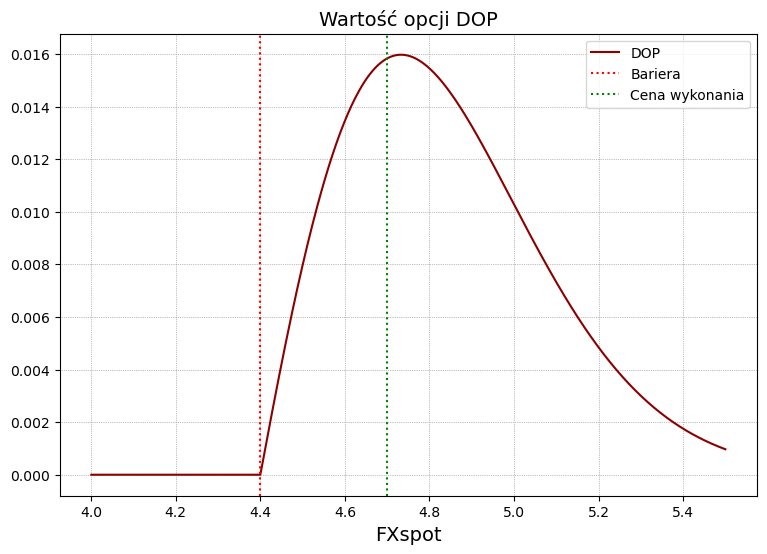

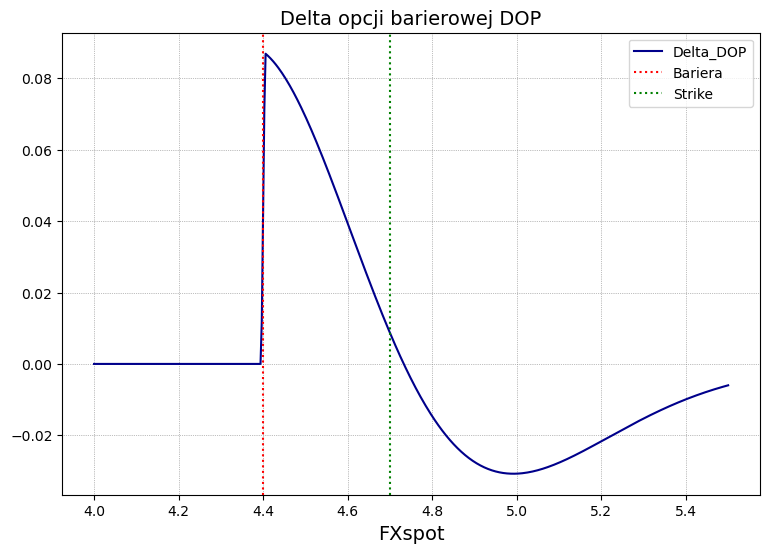

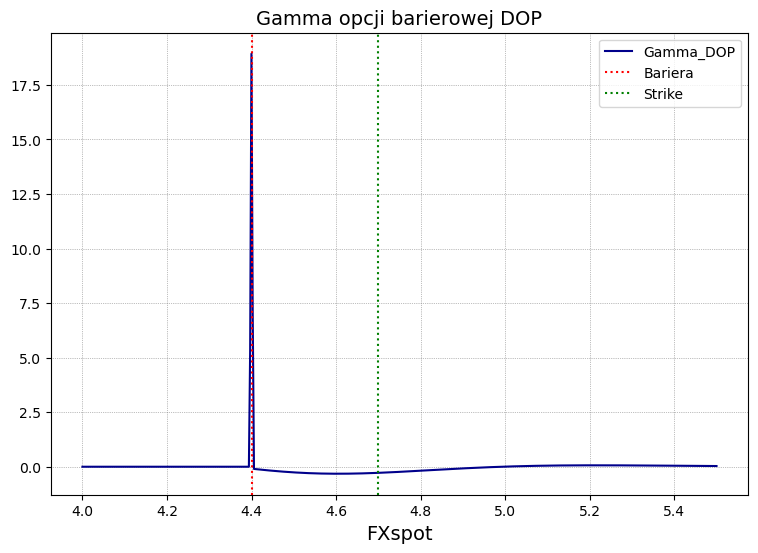

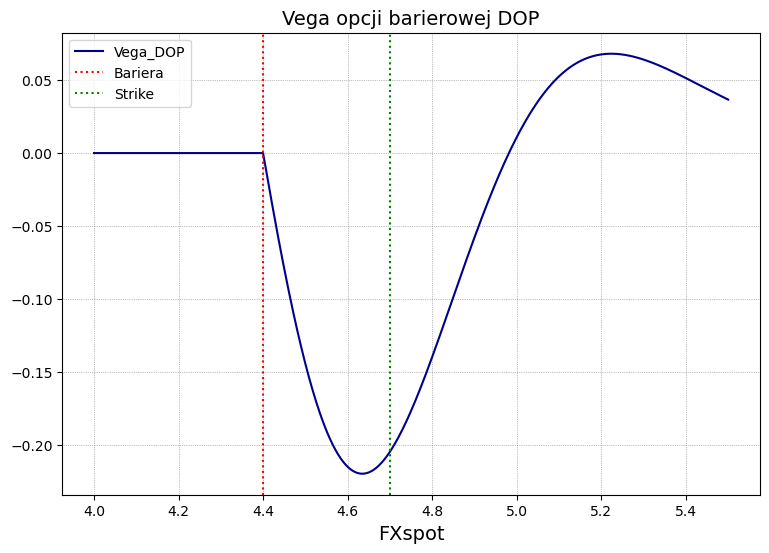

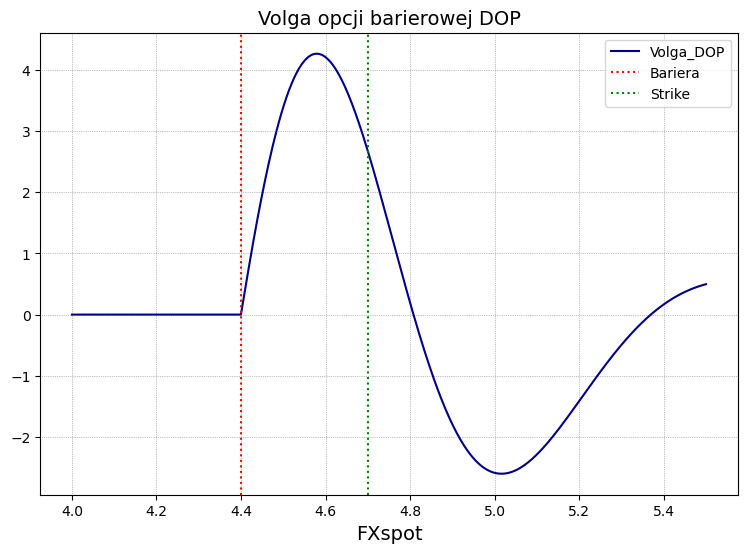

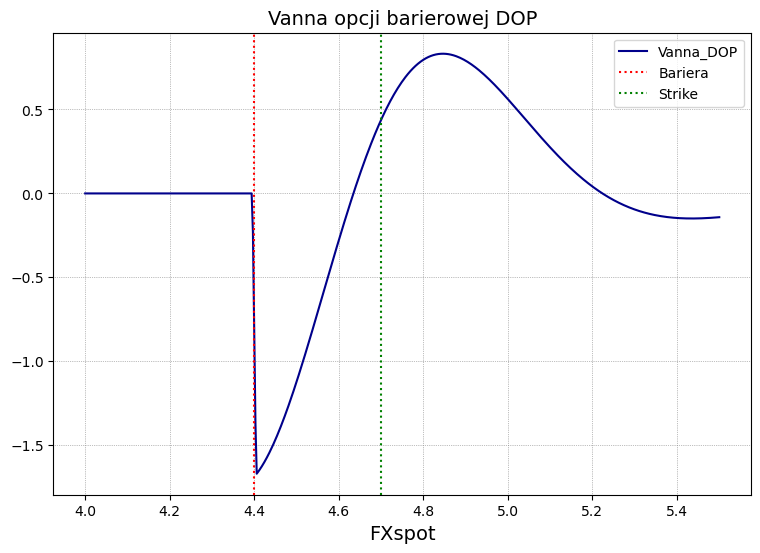

In [19]:
FXspot  = 4.50 #90
Strike  = 4.70 #100
Barrier = 4.40 #80
r_f=0.02
r_d=0.07
sig=0.15
T=1/4
df_d=np.exp(-r_d*T)
df_f=np.exp(-r_f*T)

FX_min=4.00 #60
FX_max=5.50 #140
no_fx=500
no_fx_bB=int((Barrier-FX_min)/(FX_max-FX_min)*no_fx)
no_fx_aB=no_fx-no_fx_bB
#ds=(FX_max-FX_min)/no_fx
dS=0.01*FXspot
dsig=0.01*sig

FX = np.linspace(FX_min,FX_max,no_fx)
FX_below_B = np.linspace(FX_min,Barrier,no_fx)
FX_above_B = np.linspace(Barrier,FX_max,no_fx)
CallPay = np.zeros(len(FX))
PutPay  = np.zeros(len(FX))
for i in range(len(FX)):
    CallPay[i] = if2.VanillaPay( 1,FX[i],Strike)
    PutPay[i]  = if2.VanillaPay(-1,FX[i],Strike)
Call = np.zeros(len(FX))
Put =  np.zeros(len(FX))

DIC = np.zeros(len(FX))
UIP = np.zeros(len(FX))

DOP   = np.zeros(len(FX))
V_DOP = np.zeros(len(FX))
Delta_DOP = np.zeros(len(FX))
Gamma_DOP = np.zeros(len(FX))
Vega_DOP  = np.zeros(len(FX))
Volga_DOP = np.zeros(len(FX))
Vanna_DOP = np.zeros(len(FX))

for i in range(len(FX)):
    DOP[i] = Value_DOP(FX[i],sig,r_d,r_f,Strike,Barrier,T)
    Put[i] = if2.BS_value(FX[i],df_f,df_d,T,sig,-1,Strike,1)
# Obliczanie Delty oraz Gammy
for i in range(len(FX)):
    dS = 0.001*FX[i]
    VpdS = Value_DOP(FX[i]+dS,sig,r_d,r_f,Strike,Barrier,T)
    VmdS = Value_DOP(FX[i]-dS,sig,r_d,r_f,Strike,Barrier,T)
    Delta_DOP[i]=(VpdS-VmdS)/(2.0*dS)
    Val = DOP[i]
    Vp2dS = Value_DOP(FX[i]+2*dS,sig,r_d,r_f,Strike,Barrier,T)
    Vm2dS = Value_DOP(FX[i]-2*dS,sig,r_d,r_f,Strike,Barrier,T)
    #Gamma_DOP[i] = (Vp2dS-2.0*Val+Vm2dS)/(4.0*dS**2)
    Gamma_DOP[i] = (VpdS-2.0*Val+VmdS)/(dS**2)
# Obliczanie Vegi
for i in range(len(FX)):
    DOPsig_p = Value_DOP(FX[i],sig+dsig,r_d,r_f,Strike,Barrier,T)
    DOPsig_m = Value_DOP(FX[i],sig-dsig,r_d,r_f,Strike,Barrier,T)
    Vega_DOP[i] = (DOPsig_p-DOPsig_m)/(2*dsig)
# Obliczanie Volgi
for i in range(len(FX)):
    DOPsig_p = Value_DOP(FX[i],sig+dsig,r_d,r_f,Strike,Barrier,T)
    DOPsig_m = Value_DOP(FX[i],sig-dsig,r_d,r_f,Strike,Barrier,T)
    Volga_DOP[i] = (DOPsig_p-2.0*DOP[i]+DOPsig_m)/(dsig**2)   
# Obliczanie Vanna
for i in range(len(FX)):
    dS = 0.001*FX[i]
    VpdSpdsig = Value_DOP(FX[i]+dS,sig+dsig,r_d,r_f,Strike,Barrier,T)
    VmdSpdsig = Value_DOP(FX[i]-dS,sig+dsig,r_d,r_f,Strike,Barrier,T)
    VpdSmdsig = Value_DOP(FX[i]+dS,sig-dsig,r_d,r_f,Strike,Barrier,T)
    VmdSmdsig = Value_DOP(FX[i]-dS,sig-dsig,r_d,r_f,Strike,Barrier,T)
    Vanna_DOP[i]=(VpdSpdsig - VmdSpdsig - VpdSmdsig + VmdSmdsig)/(4.0*dS*dsig)  

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji DOP",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
#plt.plot(FX,Put,color="orange",linewidth=1.5,label="Put")
plt.plot(FX,DOP,color="darkred",linewidth=1.5,label="DOP")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Cena wykonania')
plt.legend()

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Delta opcji barierowej DOP",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Delta_DOP,color="darkblue",linewidth=1.5,label="Delta_DOP")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Strike')
plt.legend()

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Gamma opcji barierowej DOP",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Gamma_DOP,color="darkblue",linewidth=1.5,label="Gamma_DOP")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Strike')
plt.legend()

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Vega opcji barierowej DOP",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Vega_DOP,color="darkblue",linewidth=1.5,label="Vega_DOP")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Strike')
plt.legend()

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Volga opcji barierowej DOP",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Volga_DOP,color="darkblue",linewidth=1.5,label="Volga_DOP")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Strike')
plt.legend()

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Vanna opcji barierowej DOP",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Vanna_DOP,color="darkblue",linewidth=1.5,label="Vanna_DOP")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Strike')
plt.legend()


# Wykresy wartości opcji barierowych

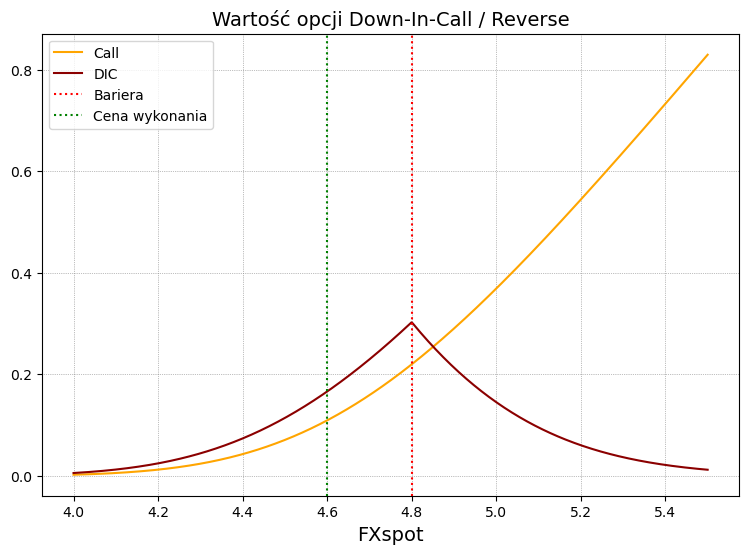

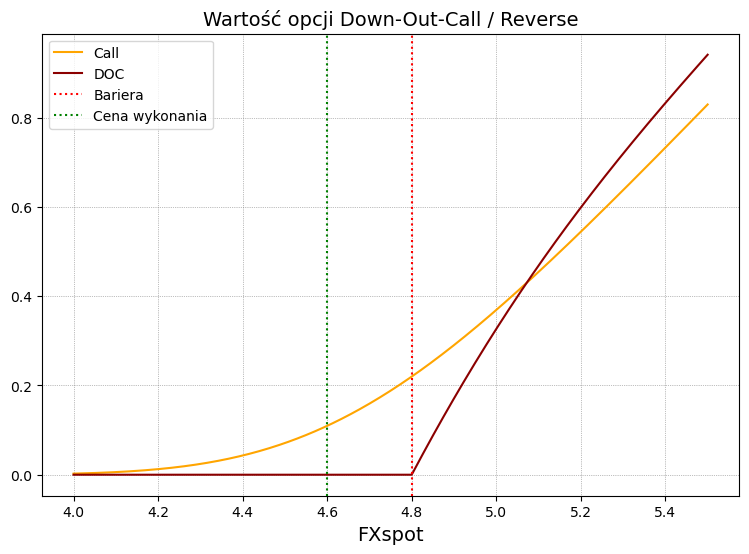

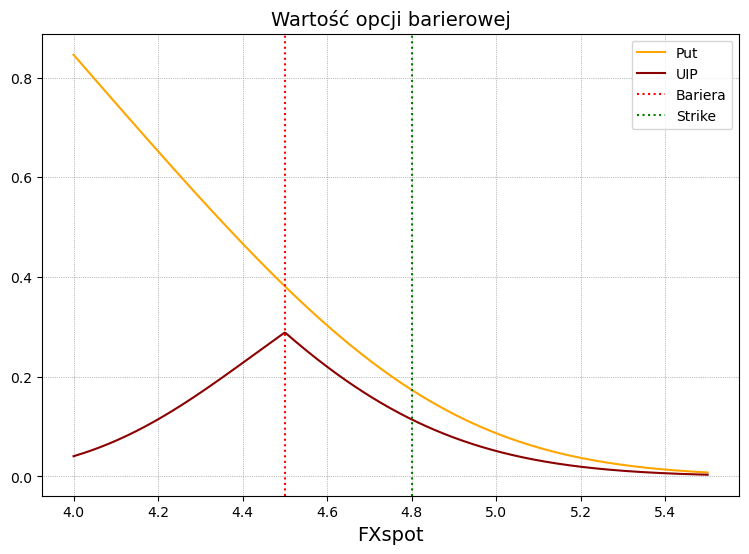

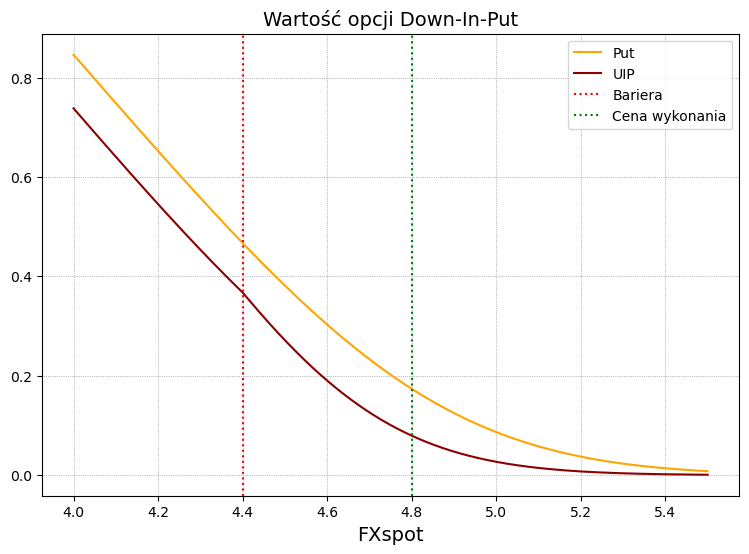

In [25]:

# Down In Call

Strike  = 4.60 #100
Barrier = 4.80 #95
DIC   = np.zeros(len(FX))
Call  = np.zeros(len(FX))
for i in range(len(FX)):
    DIC[i]  = Value_DIC(FX[i],sig,r_d,r_f,Strike,Barrier,T)
    Call[i] = if2.BS_value(FX[i],df_f,df_d,T,sig,1,Strike,1)
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji Down-In-Call / Reverse",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Call,color="orange",linewidth=1.5,label="Call")
plt.plot(FX,DIC,color="darkred",linewidth=1.5,label="DIC")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Cena wykonania')
plt.legend()

# Down Out Call

Strike  = 4.60 #100
Barrier = 4.80 #110
DOC   = np.zeros(len(FX))
Call  = np.zeros(len(FX))
for i in range(len(FX)):
    DOC[i]  = Value_DOC(FX[i],sig,r_d,r_f,Strike,Barrier,T)
    Call[i] = if2.BS_value(FX[i],df_f,df_d,T,sig,1,Strike,1)
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji Down-Out-Call / Reverse",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Call,color="orange",linewidth=1.5,label="Call")
plt.plot(FX,DOC,color="darkred",linewidth=1.5,label="DOC")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Cena wykonania')
plt.legend()

# Up In Put

Strike  = 4.80 #100
Barrier = 4.50 #85
UIP=np.zeros(len(FX))
Put=np.zeros(len(FX))
for i in range(len(FX)):
    UIP[i] = Value_UIP(FX[i],sig,r_d,r_f,Strike,Barrier,T)
    Put[i] = if2.BS_value(FX[i],df_f,df_d,T,sig,-1,Strike,1)
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji barierowej",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Put,color="orange",linewidth=1.5,label="Put")
plt.plot(FX,UIP,color="darkred",linewidth=1.5,label="UIP")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Strike')
plt.legend()

# Down In Put

Strike  = 4.80 #100
Barrier = 4.40 #85
DIP=np.zeros(len(FX))
Put=np.zeros(len(FX))
for i in range(len(FX)):
    DIP[i] = Value_DIP(FX[i],sig,r_d,r_f,Strike,Barrier,T)
    Put[i] = if2.BS_value(FX[i],df_f,df_d,T,sig,-1,Strike,1)
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji Down-In-Put",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Put,color="orange",linewidth=1.5,label="Put")
plt.plot(FX,DIP,color="darkred",linewidth=1.5,label="UIP")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Cena wykonania')
plt.legend()

# Obliczenia diagnostyczne

In [ ]:
def T_Value_UIC(FXspot,sig,r_d,r_f,Strike,Barrier,T):
    if FXspot<Barrier:            # bariera nie przekroczona, opcja nie aktywowana
        print("S<B, nie aktywowna")
        if Strike>Barrier:
            value=BS1(1,FXspot,Strike,sig,r_d,r_f,T)
            print("K>B, value", value)
        else:
            V2=BS2(1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            V3=BS3(1,-1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            V4=BS4(1,-1,FXspot,Strike,Barrier,sig,r_d,r_f,T)
            value=V2-V3+V4
            print("K<B")
            print("V2",V2)
            print("V3",V3)
            print("V4",V4)
            print("value", value)
    else:                         # bariera przekroczona, opcja aktywowana
        value=BS1(1,FXspot,Strike,sig,r_d,r_f,T)
        print("S>B, aktywowna")
        print("value", value)
    return value
FXspot=90
Strike=100
Barrier=120
r_f=0.0
r_d=0.05
sig=0.15
T=0.25
T_val=T_Value_UIC(FXspot,sig,r_d,r_f,Strike,Barrier,T)
BS_val=BS1(1,FXspot,Strike,sig,r_d,r_f,T)
print("BS: ", BS_val) 

# Próby zaprogramowania formuł z książki Iain J. Clark - strony 192-193
# Do poprawienia!!!

In [ ]:
def C(x,y,omega):
    return omega*max(omega*x,omega*y)
def d1(S,K,sig,r_d,r_f,T):
    v=r_d-r_f+0.5*sig**2
    return (np.log(S/K)+v*T)/(sig*np.sqrt(T))
def d2(S,K,sig,r_d,r_f,T):
    v=r_d-r_f-0.5*sig**2
    return (np.log(S/K)+v*T)/(sig*np.sqrt(T))
def BSF(omega,eta,X,Y,sig,r_d,r_f,d1,T):
    df_d=np.exp(-r_d*T)
    df_f=np.exp(-r_f*T)
    return omega*(df_f*X*norm.cdf(eta*d1)-df_d*Y*norm.cdf(eta*(d1-np.sqrt(T)*sig)))
def V_dic_uip(FXspot,sig,df_d,df_f,Strike,Barrier,T,N,typ):
    if typ[1]!="I": return print("Zły typ opcji")
    if typ[0]=="U": eta=-1 
    elif typ[0]=="D": eta=1
    if typ[2]=="C": omega=1 
    elif typ[2]=="P": omega=-1
    if eta*(FXspot-Barrier)<=0: 
        Value=if2.BS(omega,FXspot,sig,df_d,df_f,Strike,T,N)
    else:
        r_d=-np.log(df_d)/T
        r_f=-np.log(df_f)/T
        v=r_d-r_f-0.5*sig**2
        B2S=Barrier**2/FXspot
        A=(Barrier/FXspot)**(2.0*v/sig**2)
        CBK=C(Barrier,Strike,omega)
        d1B2S=d1(B2S,CBK,sig,r_d,r_f,T)
        V1=if2.BS(omega,B2S,sig,df_d,df_f,CBK,T,1)
 #       V1=BSF(omega,eta,B2S,CBK,sig,r_d,r_f,d1B2S,T)
        d2B2S=d2(B2S,CBK,sig,r_d,r_f,T)
        C1=eta*(CBK-Strike)*df_d*norm.cdf(omega*d2B2S)
        if eta*(Barrier-Strike)>0: 
            d1SK=d1(FXspot,Strike,sig,r_d,r_f,T)
            V2K=BSF(omega,eta,FXspot,Strike,sig,r_d,r_f,d1SK,T)
            d1SB=d1(FXspot,Barrier,sig,r_d,r_f,T)
            V2KB=BSF(omega,eta,FXspot,Strike,sig,r_d,r_f,d1SB,T)
            d2BS=d2(Barrier,FXspot,sig,r_d,r_f,T)
            D=eta*(Barrier-Strike)*df_d*norm.cdf(omega*d2BS)
            SecTerm=V2K-V2KB+D 
        else: SecTerm=0
        Value=A*V1+C1+SecTerm
    return Value

def V_uic_dip(FXspot,sig,df_d,df_f,Strike,Barrier,T,N,typ):
    if typ[1]!="I": return print("Zły typ opcji")
    if typ[0]=="U":   eta=-1 
    elif typ[0]=="D": eta=1
    if typ[2]=="C":   omega=1 
    elif typ[2]=="P": omega=-1
    if eta*(FXspot-Barrier)<=0: 
        Value=if2.BS(omega,FXspot,sig,df_d,df_f,Strike,T,N)
    else:
        r_d=-np.log(df_d)/T
        r_f=-np.log(df_f)/T
        v=r_d-r_f-0.5*sig**2
        B2S=Barrier**2/FXspot
        A=(Barrier/FXspot)**(2.0*v/(sig**2))
        CBK=C(Barrier,Strike,omega)
        d1SCBK=d1(FXspot,CBK,sig,r_d,r_f,T)
        V1=BSF(omega,-eta,FXspot,CBK,sig,r_d,r_f,d1SCBK,T)
        d2SCBK=d2(FXspot,CBK,sig,r_d,r_f,T)
        C1=eta*(CBK-Strike)*df_d*norm.cdf(omega*d2SCBK)
        if eta*(Strike-Barrier)>0: 
            d2B2SK=d2(B2S,Strike,sig,r_d,r_f,T)
            V2B2SK=BSF(omega,eta,B2S,Strike,sig,r_d,r_f,d2B2SK,T)
            d2B2SB=d2(B2S,Barrier,sig,r_d,r_f,T)
            V2B2SB=BSF(omega,eta,B2S,Barrier,sig,r_d,r_f,d2B2SB,T) 
            d2SB=d2(FXspot,Barrier,sig,r_d,r_f,T)
            D=eta*(Barrier-Strike)*df_d*norm.cdf(omega*d2SB)
            SecTerm=A*(V2B2SK-V2B2SB)+D
        else: SecTerm=0
        Value=V1-C1-SecTerm  
    return Value

In [ ]:
def V_dic_uip(FXspot,sig,df_d,df_f,Strike,Barrier,T,N,typ):
    if typ[1]!="I": return print("Zły typ opcji")
    if typ[0]=="U": eta=-1 
    elif typ[0]=="D": eta=1
    if typ[2]=="C": omega=1 
    elif typ[2]=="P": omega=-1
    if eta*(FXspot-Barrier)<=0: 
        Value=if2.BS(omega,FXspot,sig,df_d,df_f,Strike,T,N)
        print("ValueBS: ", Value)
    else:
        r_d=-np.log(df_d)/T
        r_f=-np.log(df_f)/T
        v=r_d-r_f-0.5*sig**2
        if eta*(Barrier-Strike)>0: 
            B2S=Barrier**2/FXspot
            A=(Barrier/FXspot)**(2.0*v/sig**2)
            CBK=C(Barrier,Strike,omega)
            print("CBK: ", CBK)
            d1B2S=d1(B2S,CBK,sig,r_d,r_f,T)
            V1=if2.BS(omega,B2S,sig,df_d,df_f,CBK,T,1)
            print("V1: ", V1)
 #       V1=BSF(omega,eta,B2S,CBK,sig,r_d,r_f,d1B2S,T)
            d2B2S=d2(B2S,CBK,sig,r_d,r_f,T)
            C1=eta*(CBK-Strike)*df_d*norm.cdf(omega*d2B2S)
            print("C1: ", C1)
            FirstTerm=A*V1+C1
        else: FirstTerm=0  
        print("FirstTerm: ", FirstTerm)
        d1SK=d1(FXspot,Strike,sig,r_d,r_f,T)
        V2K=BSF(omega,eta,FXspot,Strike,sig,r_d,r_f,d1SK,T)
        print("V2K: ", V2K)
        d1SB=d1(FXspot,Barrier,sig,r_d,r_f,T)
        V2KB=BSF(omega,eta,FXspot,Strike,sig,r_d,r_f,d1SB,T)
        print("V2KB: ", V2KB)
        d2BS=d2(Barrier,FXspot,sig,r_d,r_f,T)
        D=eta*(Barrier-Strike)*df_d*norm.cdf(omega*d2BS)
        print("D: ", D)
        SecTerm=V2K-V2KB-D 
        Value=FirstTerm+SecTerm
        print("Value: ", Value)
    return Value
FXspot=4.70001
Strike=4.30
Barrier=4.70
r_f=0.02
r_d=0.06
sig=0.30
T=0.25
N=1
typ="DIP"
df_d=np.exp(-r_d*T)
df_f=np.exp(-r_f*T)
test=V_dic_uip(FXspot,sig,df_d,df_f,Strike,Barrier,T,N,"DIC")

In [ ]:
#FXspot=4.50
Strike=4.70
Barrier=4.30
r_f=0.02
r_d=0.06
sig=0.30
T=0.25
N=1
typ="DIP"
df_d=np.exp(-r_d*T)
df_f=np.exp(-r_f*T)
#test=V_dic_uip(FXspot,sig,df_d,df_f,Strike,Barrier,T,N,typ)
#test=V_uic_dip(FXspot,sig,df_d,df_f,Strike,Barrier,T,N,typ)
#print(test)
FX_min=3.50
FX_max=5.50
no_fx=500
FX=np.linspace(FX_min,FX_max,no_fx)
CallPay=np.zeros(len(FX))
PutPay=np.zeros(len(FX))
for i in range(len(FX)):
    CallPay[i]=if2.VanillaPay(1,FX[i],Strike)
    PutPay[i]=if2.VanillaPay(-1,FX[i],Strike)
DIP=np.zeros(len(FX))
UIC=np.zeros(len(FX))
Call=np.zeros(len(FX))
Put=np.zeros(len(FX))
for i in range(len(FX)):
    DIP[i]=V_uic_dip(FX[i],sig,df_d,df_f,Strike,Barrier,T,N,typ)
    Call[i]=if2.BS(1,FX[i],sig,df_d,df_f,Strike,T,N)
    Put[i]=if2.BS(-1,FX[i],sig,df_d,df_f,Strike,T,N)
typ="UIC"
for i in range(len(FX)):
    UIC[i]=V_uic_dip(FX[i],sig,df_d,df_f,Strike,Barrier,T,N,typ)
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji barierowej",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,PutPay,color="lightblue",linewidth=1.5,label="put payout")
#plt.plot(FX,Call,color="orange",linewidth=1.5,label="call")
plt.plot(FX,Put,color="orange",linewidth=1.5,label="put")
plt.plot(FX,DIP,color="darkgreen",linewidth=1.5,label="DIP")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Strike')
plt.legend()

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji barierowej",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Call,color="orange",linewidth=1.5,label="call")
plt.plot(FX,UIC,color="darkred",linewidth=1.5,label="UIC")
plt.plot(FX,CallPay,color="lightblue",linewidth=1.5,label="call payout")
#plt.plot(FX,UIC-UIP,color="darkblue",linewidth=1.5,label="DIC-DIP")
#plt.plot(FX,df_f*FX-df_d*Strike,color="orange",linewidth=1.5,label="FXfwd")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Strike')
plt.legend()

In [ ]:
#FXspot=4.50
Strike=4.30
Barrier=4.70
r_f=0.02
r_d=0.06
sig=0.30
T=0.25
N=1
typ="DIC"
df_d=np.exp(-r_d*T)
df_f=np.exp(-r_f*T)
#test=V_dic_uip(FXspot,sig,df_d,df_f,Strike,Barrier,T,N,typ)
#test=V_uic_dip(FXspot,sig,df_d,df_f,Strike,Barrier,T,N,typ)
#print(test)
FX_min=3.50
FX_max=5.50
no_fx=500
FX=np.linspace(FX_min,FX_max,no_fx)
CallPay=np.zeros(len(FX))
PutPay=np.zeros(len(FX))
for i in range(len(FX)):
    CallPay[i]=if2.VanillaPay(1,FX[i],Strike)
    PutPay[i]=if2.VanillaPay(-1,FX[i],Strike)
DIC=np.zeros(len(FX))
UIP=np.zeros(len(FX))
Call=np.zeros(len(FX))
Put=np.zeros(len(FX))
for i in range(len(FX)):
    DIC[i]=V_dic_uip(FX[i],sig,df_d,df_f,Strike,Barrier,T,N,typ)
    Call[i]=if2.BS(1,FX[i],sig,df_d,df_f,Strike,T,N)
    Put[i]=if2.BS(-1,FX[i],sig,df_d,df_f,Strike,T,N)
typ="UIP"
for i in range(len(FX)):
    UIP[i]=V_dic_uip(FX[i],sig,df_d,df_f,Strike,Barrier,T,N,typ)
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji barierowej",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,PutPay,color="lightblue",linewidth=1.5,label="put payout")
#plt.plot(FX,Call,color="orange",linewidth=1.5,label="call")
plt.plot(FX,Put,color="orange",linewidth=1.5,label="put")
plt.plot(FX,UIP,color="darkgreen",linewidth=1.5,label="UIP")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Strike')
plt.legend()

fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji barierowej",fontsize=14)
axl.set_xlabel("FXspot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)
plt.plot(FX,Call,color="orange",linewidth=1.5,label="call")
plt.plot(FX,DIC,color="darkred",linewidth=1.5,label="DIC")
plt.plot(FX,CallPay,color="lightblue",linewidth=1.5,label="call payout")
#plt.plot(FX,UIC-UIP,color="darkblue",linewidth=1.5,label="DIC-DIP")
#plt.plot(FX,df_f*FX-df_d*Strike,color="orange",linewidth=1.5,label="FXfwd")
plt.axvline(Barrier,color="red",linestyle='dotted',label='Bariera')
plt.axvline(Strike,color="green",linestyle='dotted',label='Strike')
plt.legend()

In [ ]:
FXspot=1.205
T=94/365
df_f=0.994585501
df_d=0.990275201
r_d=-np.log(df_d)/T
r_f=-np.log(df_f)/T
sig_atm=0.0905
sig_rr=-0.0050
sig_bf= 0.0013
sig_25c=sig_atm+0.5*sig_rr+sig_bf
sig_25p=sig_atm-0.5*sig_rr+sig_bf
FXfwd=FXspot*df_f/df_d
K_ATM=FXfwd*np.exp(0.5*sig_atm**2*T)
# K_ATM=if2.StrikeFromDelta("spot","std", 1, 0.50,FXspot,sig_atm,df_d,df_f,T)
K_25C=if2.StrikeFromDelta("spot","std", 1, 0.25,FXspot,sig_25c,df_d,df_f,T)
K_25P=if2.StrikeFromDelta("spot","std",-1,-0.25,FXspot,sig_25p,df_d,df_f,T)
Strike=1.3
Barrier=1.1
#volK=if2.vv_int1(K,K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)
ValueB_BS=Value_DOP(FXspot,sig_atm,r_d,r_f,Strike,Barrier,T)
dsig=0.0001
sig_atm_p=sig_atm+dsig
sig_atm_m=sig_atm-dsig
VegaB=(Value_DOP(FXspot,sig_atm_p,r_d,r_f,Strike,Barrier,T)-Value_DOP(FXspot,sig_atm_m,r_d,r_f,Strike,Barrier,T))/(2*dsig)
VolgaB=(Value_DOP(FXspot,sig_atm_p,r_d,r_f,Strike,Barrier,T)-2*ValueB_BS+Value_DOP(FXspot,sig_atm_m,r_d,r_f,Strike,Barrier,T))/(dsig**2)
dFX=0.005*FXspot
Val_Sp_sig_p=Value_DOP(FXspot+dFX,sig_atm_p,r_d,r_f,Strike,Barrier,T)
Val_Sm_sig_p=Value_DOP(FXspot-dFX,sig_atm_p,r_d,r_f,Strike,Barrier,T)
Val_Sp_sig_m=Value_DOP(FXspot+dFX,sig_atm_m,r_d,r_f,Strike,Barrier,T)
Val_Sm_sig_m=Value_DOP(FXspot-dFX,sig_atm_m,r_d,r_f,Strike,Barrier,T)
VannaB=(Val_Sp_sig_p-Val_Sm_sig_p-Val_Sp_sig_m+Val_Sm_sig_m)/(4*dFX*dsig)
VegaK1 =if2.VegaBS(FXspot, sig_atm, df_d, df_f, K_25P, T, 1)
VegaK2 =if2.VegaBS(FXspot, sig_atm, df_d, df_f, K_ATM, T, 1)
VegaK3 =if2.VegaBS(FXspot, sig_atm, df_d, df_f, K_25C, T, 1)
VannaK1=if2.VannaBS(FXspot, sig_atm, df_d, df_f, K_25P, T, 1)
VannaK2=if2.VannaBS(FXspot, sig_atm, df_d, df_f, K_ATM, T, 1)
VannaK3=if2.VannaBS(FXspot, sig_atm, df_d, df_f, K_25C, T, 1)
VolgaK1=if2.VolgaBS(FXspot, sig_atm, df_d, df_f, K_25P, T, 1)
VolgaK2=if2.VolgaBS(FXspot, sig_atm, df_d, df_f, K_ATM, T, 1)
VolgaK3=if2.VolgaBS(FXspot, sig_atm, df_d, df_f, K_25C, T, 1)
VV=np.array([[VegaK1,VegaK2,VegaK3],
             [VolgaK1,VolgaK2,VolgaK3],
             [VannaK1,VannaK2,VannaK3]])
BV=np.array([VegaB,VolgaB,VannaB])
X=np.linalg.inv(VV).dot(BV)
P1_mkt=if2.BS(-1, FXspot, sig_25p, df_d, df_f, K_25P, T, 1)
P1_BS=if2.BS(-1, FXspot, sig_atm, df_d, df_f, K_25P, T, 1)
OH1=P1_mkt-P1_BS
OH2=0
C3_mkt=if2.BS(1, FXspot, sig_25c, df_d, df_f, K_25C, T, 1)
C3_BS=if2.BS(1, FXspot, sig_atm, df_d, df_f, K_25C, T, 1)
OH3=C3_mkt-C3_BS
OH=np.array([OH1,OH2,OH3])
ValueB_VV=ValueB_BS+X.dot(OH)
print("Wycena BS DOP %6.4f" %ValueB_BS)
print("Wycena VV DOP %6.4f" %ValueB_VV)